In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import IPython
import tensorflow_datasets as tfds
from pytz import timezone
from datetime import datetime
import scipy.io as sio
import math
from skimage.transform import resize
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


## Help functions
### Inception score

In [2]:
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)
    return np.asarray(images_list)

# input images have the shape 299x299x3, pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    model = InceptionV3()
    scores = list()
    n_part = math.floor(images.shape[0] / n_split)
    for i in range(n_split):
        ix_start, ix_end = i * n_part, (i + 1) * n_part
        subset = images[int(ix_start):int(ix_end)]
        subset = scale_images(subset, (299, 299, 3))
        subset = subset.astype('float32')
        subset = preprocess_input(subset)
        p_yx = model.predict(subset)
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        sum_kl_d = kl_d.sum(axis=1)
        avg_kl_d = np.mean(sum_kl_d)
        is_score = np.exp(avg_kl_d)
        scores.append(is_score)
    is_avg, is_std = np.mean(scores), np.std(scores)
    return is_avg, is_std

def IS(model, n_sample, noise_dim): 
    # n_sample=1000 will take less than 1 minute
    new_seed = tf.random.normal([n_sample, noise_dim])
    predictions = model(new_seed, training=False)
    predictions = (predictions + 1) / 2 * 255
    is_avg, is_std = calculate_inception_score(predictions)
    print('score is {} +- {}'.format(is_avg, is_std))
    return is_avg, is_std

### Loss
label smooth and random noise

In [3]:
def discriminator_loss(real_output, fake_output):
    if tf.random.uniform([1]) < 0.05:
        real_output, fake_output = fake_output, real_output
    real_loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1, from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1, from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

### Data preprocessing and plot save

In [4]:
def generate_and_save_images(model, epoch, test_input,savedir):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        if DATA == 'mnist':
            plt.imshow(np.uint8(predictions[i, :, :, 0] * 127.5 + 127.5), cmap='gray')
        elif DATA.lower() == 'svhn':
            plt.imshow(np.uint8(predictions[i, :, :, :] * 127.5 + 127.5))
        plt.axis('off')
    path = os.path.join(savedir, 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.savefig(path)
    plt.close('all')

    
@tf.function
def format_example(data):
    # First, convert the data type to tf.float32
    image = data["image"]
#     label = data["label"]
    image =  tf.cast(image, tf.float32)
    # Second, normalize the image
    image = (image - 127.5) / 127.5
    # Third, resize the image 
    image = tf.image.resize(image,[32,32])
    return image

def get_train_data(name = 'svhn'):
    
    if name.lower() == 'svhn':
        
        (train_data,_), info = tfds.load(name="svhn_cropped", split=["train","test"], shuffle_files=True, with_info=True )

        return train_data.map(format_example).shuffle(50000).batch(64)
    
    elif name.lower() =='mnist':
        
        (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
        train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
        train_images = (train_images - 127.5) / 127.5
        train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(50000).batch(64)
        return train_images

### Model structures

In [5]:
def make_generator_model_mnist():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model_mnist():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def make_generator_model_svhn():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((4, 4, 256)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    #model.add(layers.Cropping2D(1))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    #model.add(layers.Cropping2D(1))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #model.add(layers.Cropping2D(1))
    assert model.output_shape == (None, 32, 32, 3)
    return model

def make_discriminator_model_svhn():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (4, 4), strides=(1, 1), padding='same', use_bias=False, input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4, 4), strides=(1, 1),padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (4, 4), strides=(1, 1),use_bias=False, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

### Training function

In [6]:
@tf.function
def train_step(images):
    noise = tf.random.normal([64, 100])
    
    g_loss = generator_loss
    d_loss = discriminator_loss
        
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss    
    
def train(dataset, epochs, savedir):
    IS_mean = []
    IS_std = []
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        i = 0
        g_loss = 0
        d_loss = 0
        for image_batch in dataset:
            i += 1
            g_tensor, d_tensor = train_step(image_batch)
            g_loss += float(g_tensor.numpy())
            d_loss += float(d_tensor.numpy())
        
        G_loss.append(g_loss / i)
        D_loss.append(d_loss / i)
        # Produce images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,savedir)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            mean, std = IS(generator, 1000, 100)
            IS_mean.append(mean)
            IS_std.append(std)
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', G_loss[-1], step=epoch)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', D_loss[-1], step=epoch) 
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # clear outputs
    display.clear_output(wait=True)
    
    # save IS score and Loss plot
    IS_mean = np.array(IS_mean)
    IS_std = np.array(IS_std)
    IS_df = pd.DataFrame({'mean':IS_mean, 'mean+std':IS_mean+IS_std, 'mean-std':IS_mean-IS_std, 'std':IS_std})
    IS_df.index = [5 * (x + 1) for x in range(IS_df.shape[0])]
    Loss_df = pd.DataFrame({'Generater':G_loss, 'Discriminator':D_loss})
    
    df_path = os.path.join(savedir, 'IS_score.csv')
    IS_df.to_csv(path_or_buf=df_path, index=False)
    df_path2 = os.path.join(savedir, 'Loss.csv')
    Loss_df.to_csv(path_or_buf=df_path2, index=False)
    print('Inception score and loss save complete')
    
    path = os.path.join(savedir, 'IS_score_trend.png')
    fig = plt.figure(figsize=(6, 6))
    plt.plot(IS_df[['mean','mean+std','mean-std']])
    plt.title('Inception Scores')
    plt.legend(IS_df[['mean','mean+std','mean-std']].columns, loc='best')
    plt.savefig(path)
    #plt.close('all')
    
    path2 = os.path.join(savedir, 'Loss_trend.png')
    fig2 = plt.figure(figsize=(6, 6))
    plt.plot(Loss_df)
    plt.title('Validation Losses')
    plt.legend(Loss_df.columns, loc='best')
    plt.savefig(path2)
    
    # Generate after the final epoch
    generate_and_save_images(generator,
                           epochs,
                           seed,savedir)

In [7]:
(train_mnist,_),(_,_) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

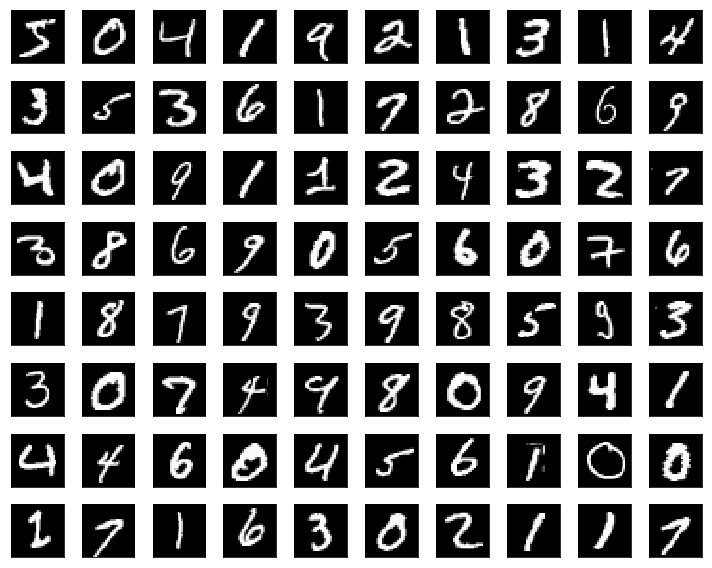

In [8]:
plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(train_mnist[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
del train_mnist

In [9]:
generator = make_generator_model_mnist()
discriminator = make_discriminator_model_mnist()

In [10]:
train_data = get_train_data('mnist')

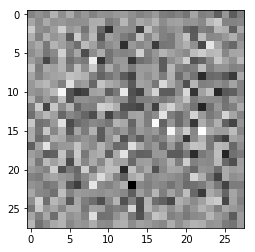

In [11]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise,training = False)
plt.imshow(generated_image[0, :, :, 0],cmap = 'gray')

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.5, beta_2 = 0.99999, decay = 1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate =1e-4, beta_1 = 0.5, beta_2 = 0.99999, decay = 1e-5)

In [13]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
now = datetime.now(timezone('US/Eastern'))

subfile = now.strftime("%m_%d_%H_%M")

filedir = os.path.join('saveimage',subfile)

checkpoint_dir = filedir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

if (not os.path.exists('saveimage')):
    os.mkdir('saveimage')

if (not os.path.isfile(filedir)):
    os.mkdir(filedir)

savedir = filedir
print(savedir)

saveimage/12_14_17_54


In [15]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
gen_log_dir = 'logs/gradient_tape/' + current_time + '/gen'
disc_log_dir = 'logs/gradient_tape/' + current_time + '/disc'
train_summary_writer = tf.summary.create_file_writer(gen_log_dir)
test_summary_writer = tf.summary.create_file_writer(disc_log_dir)

In [16]:
DATA = 'mnist'
train(train_data,EPOCHS,savedir)

Inception score and loss save complete


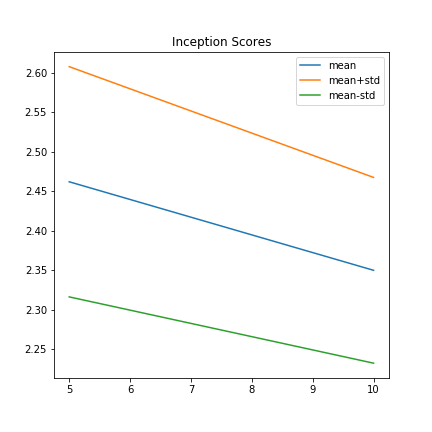

In [17]:
from IPython.display import Image
Image(filename= (savedir+'/IS_score_trend.png'))

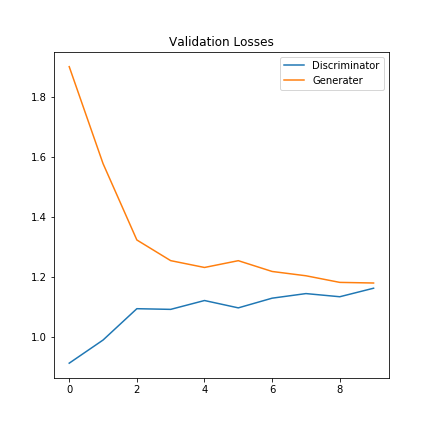

In [18]:
Image(filename = (savedir+'/Loss_trend.png'))

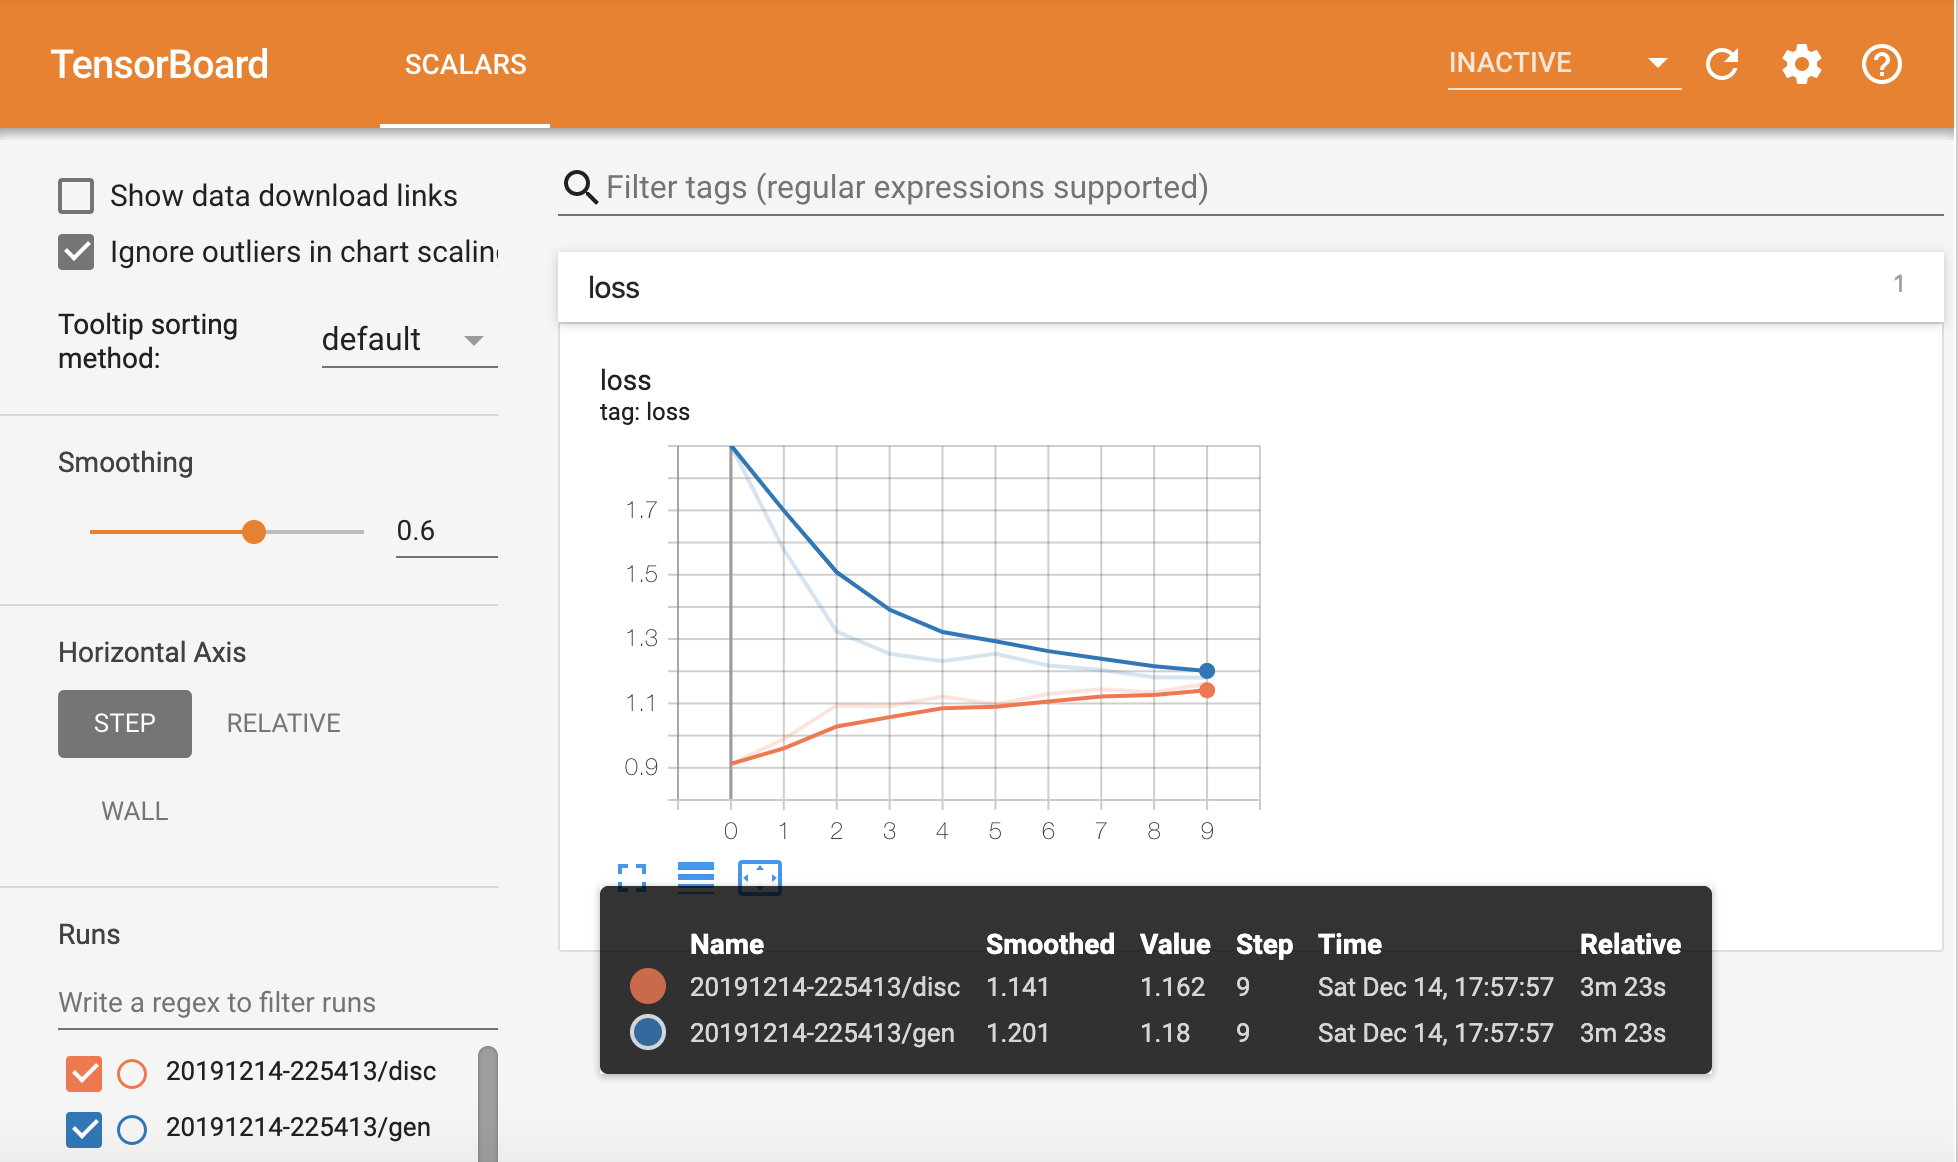

In [36]:
display.Image('mnist.png')

In [19]:
anim_file = subfile+'gan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(filedir+'/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

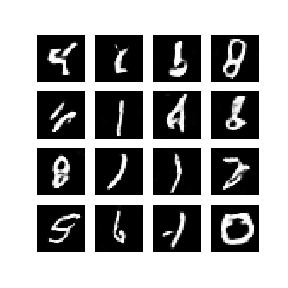

In [20]:
display.Image(savedir+'/image_at_epoch_{:04d}.png'.format(EPOCHS))

In [ ]:
Image(filename='12_14_17_54gan.gif.png')

In [21]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

Total memory: 17071734784
Free memory: 673054720
Used memory: 16398680064


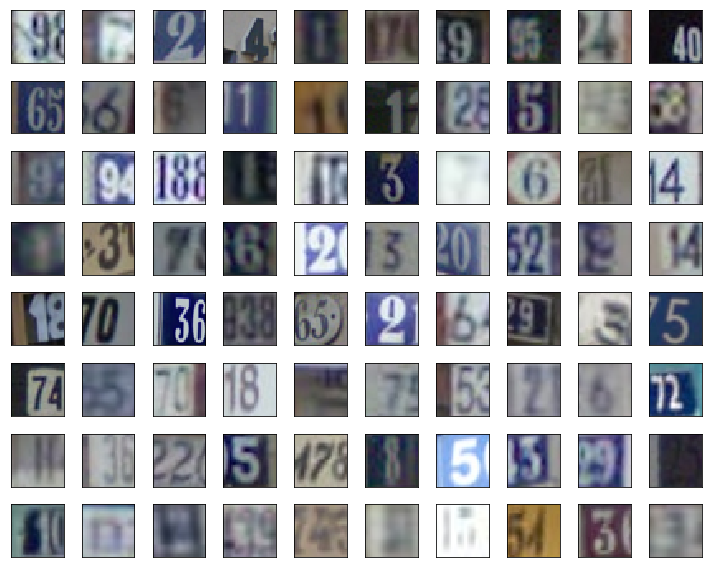

In [22]:
(train_data,_) = tfds.load(name="svhn_cropped", split=["train","test"], shuffle_files=True )
train_iter = iter(train_data)
plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(next(train_iter)['image'])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
del train_data

In [23]:
generator = make_generator_model_svhn()
discriminator = make_discriminator_model_svhn()

In [24]:
train_data = get_train_data('svhn')

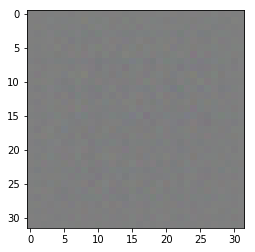

In [25]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :]* 127.5 + 127.5)/255)

In [26]:
now = datetime.now(timezone('US/Eastern'))

subfile = now.strftime("%m_%d_%H_%M")

filedir = os.path.join('saveimage',subfile)

checkpoint_dir = filedir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

if (not os.path.exists('saveimage')):
    os.mkdir('saveimage')

if (not os.path.isfile(filedir)):
    os.mkdir(filedir)

savedir = filedir
print(savedir)

saveimage/12_14_17_58


In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([64, 100])
    
    g_loss = generator_loss
    d_loss = discriminator_loss
        
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss    
    
def train(dataset, epochs, savedir):
    IS_mean = []
    IS_std = []
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        i = 0
        g_loss = 0
        d_loss = 0
        for image_batch in dataset:
            i += 1
            g_tensor, d_tensor = train_step(image_batch)
            g_loss += float(g_tensor.numpy())
            d_loss += float(d_tensor.numpy())
        
        G_loss.append(g_loss / i)
        D_loss.append(d_loss / i)
        # Produce images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,savedir)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            mean, std = IS(generator, 1000, 100)
            IS_mean.append(mean)
            IS_std.append(std)
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', G_loss[-1], step=epoch)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', D_loss[-1], step=epoch) 
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # clear outputs
    display.clear_output(wait=True)
    
    # save IS score and Loss plot
    IS_mean = np.array(IS_mean)
    IS_std = np.array(IS_std)
    IS_df = pd.DataFrame({'mean':IS_mean, 'mean+std':IS_mean+IS_std, 'mean-std':IS_mean-IS_std, 'std':IS_std})
    IS_df.index = [5 * (x + 1) for x in range(IS_df.shape[0])]
    Loss_df = pd.DataFrame({'Generater':G_loss, 'Discriminator':D_loss})
    
    df_path = os.path.join(savedir, 'IS_score.csv')
    IS_df.to_csv(path_or_buf=df_path, index=False)
    df_path2 = os.path.join(savedir, 'Loss.csv')
    Loss_df.to_csv(path_or_buf=df_path2, index=False)
    print('Inception score and loss save complete')
    
    path = os.path.join(savedir, 'IS_score_trend.png')
    fig = plt.figure(figsize=(6, 6))
    plt.plot(IS_df[['mean','mean+std','mean-std']])
    plt.title('Inception Scores')
    plt.legend(IS_df[['mean','mean+std','mean-std']].columns, loc='best')
    plt.savefig(path)
    #plt.close('all')
    
    path2 = os.path.join(savedir, 'Loss_trend.png')
    fig2 = plt.figure(figsize=(6, 6))
    plt.plot(Loss_df)
    plt.title('Validation Losses')
    plt.legend(Loss_df.columns, loc='best')
    plt.savefig(path2)
    
    # Generate after the final epoch
    generate_and_save_images(generator,
                           epochs,
                           seed,savedir)

In [28]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
gen_log_dir = 'logs/gradient_tape/' + current_time + '/gen'
disc_log_dir = 'logs/gradient_tape/' + current_time + '/disc'
train_summary_writer = tf.summary.create_file_writer(gen_log_dir)
test_summary_writer = tf.summary.create_file_writer(disc_log_dir)

In [29]:
DATA = 'svhn'
train(train_data, EPOCHS,savedir)

Inception score and loss save complete


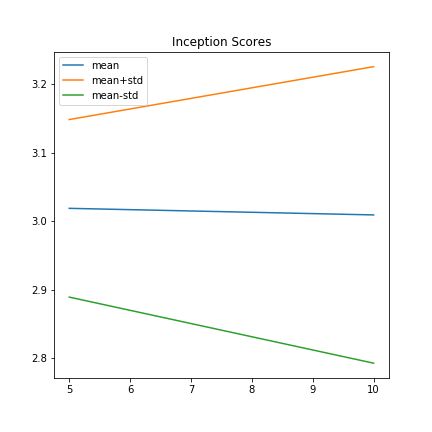

In [30]:
Image(filename= (savedir+'/IS_score_trend.png'))

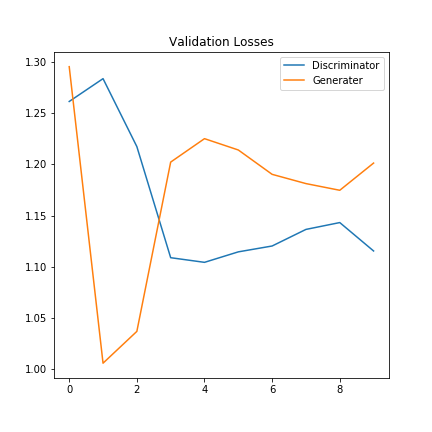

In [31]:
Image(filename = (savedir+'/Loss_trend.png'))

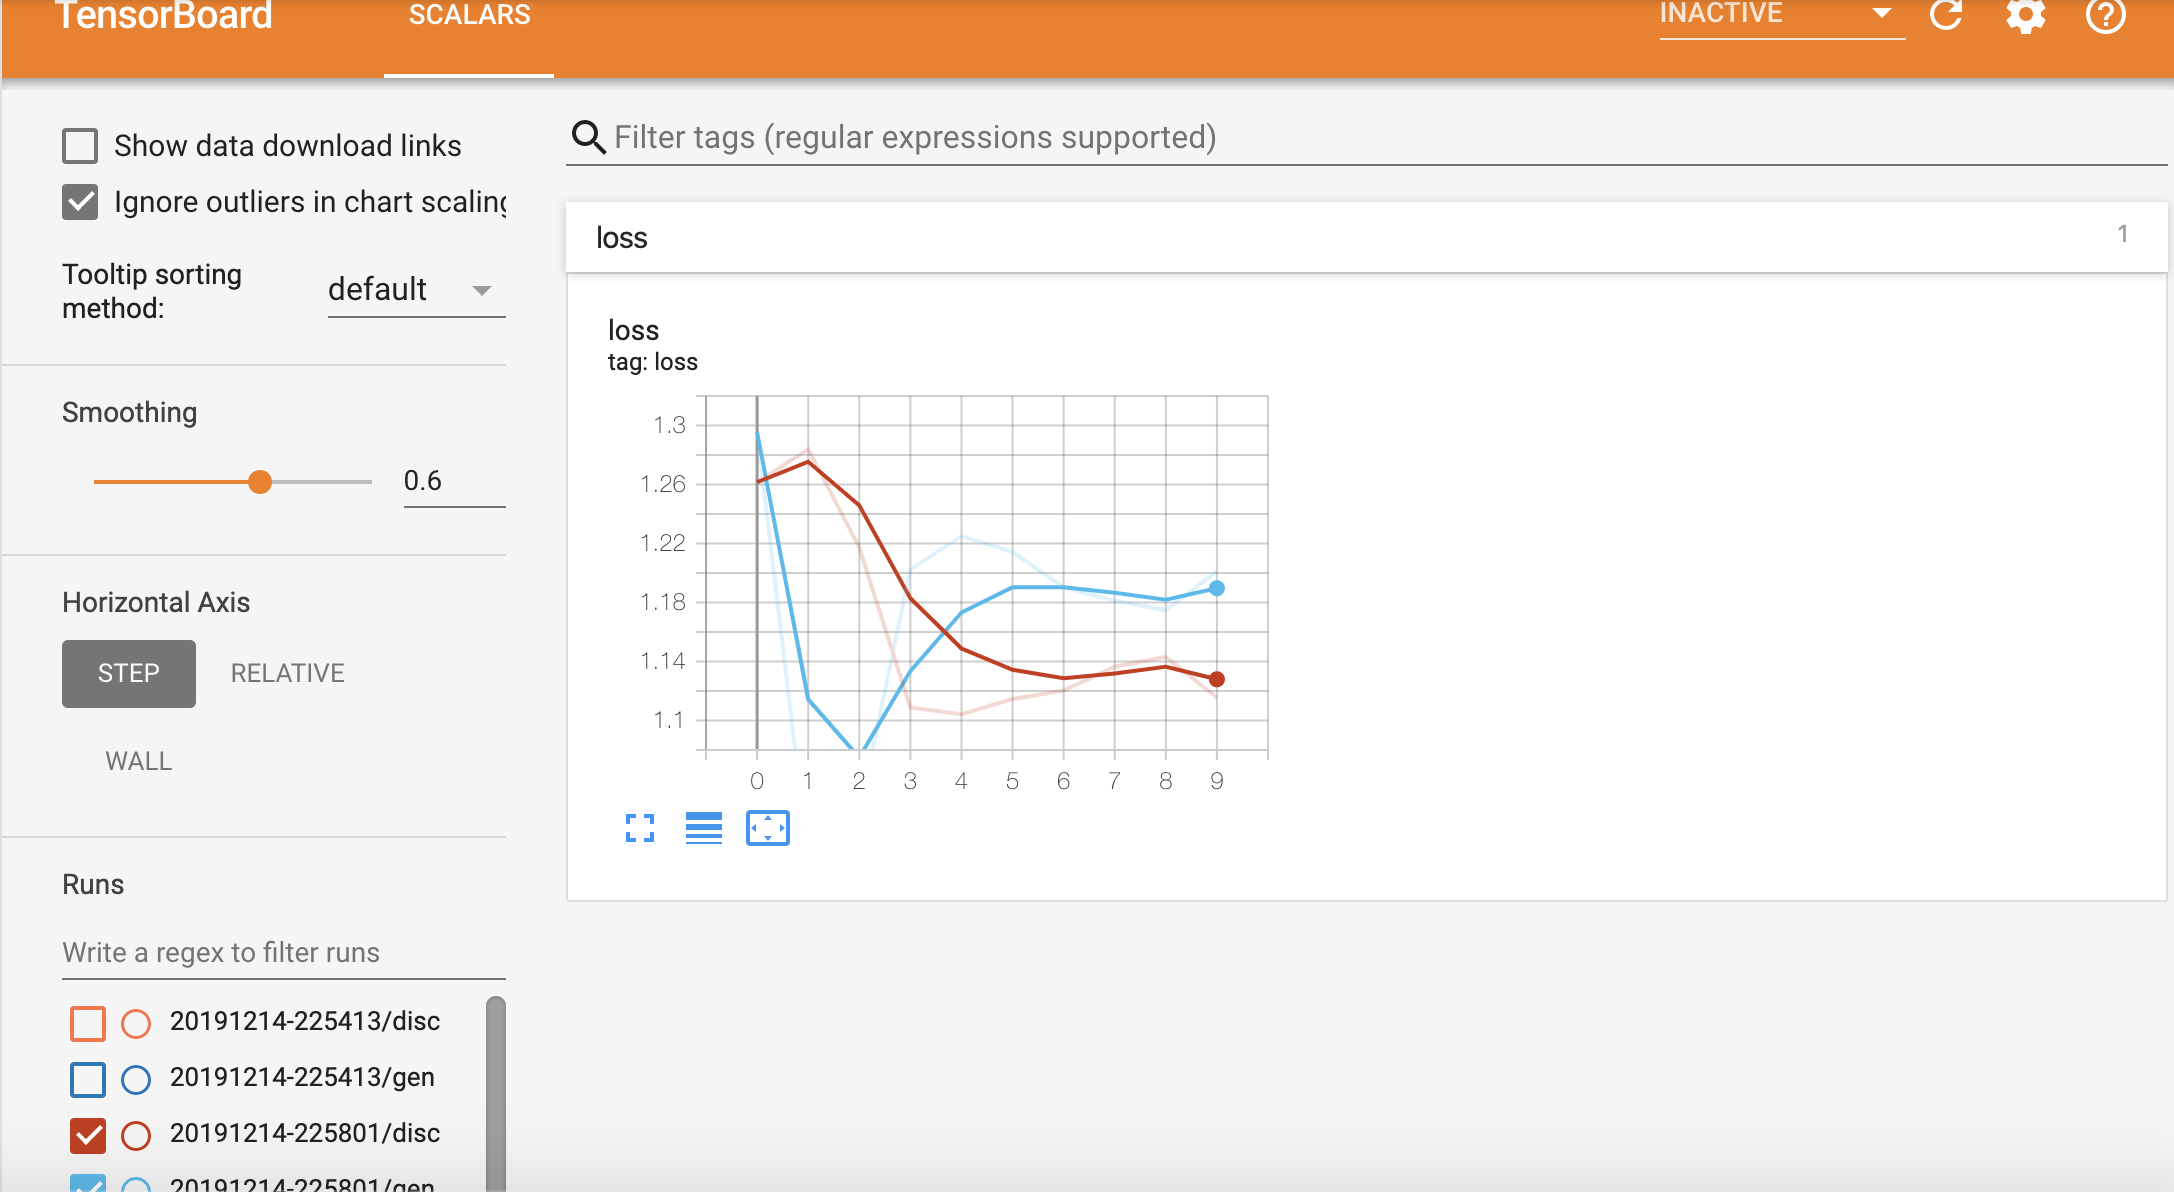

In [37]:
display.Image('svhn.png')

In [32]:
anim_file = subfile+'gan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(filedir+'/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

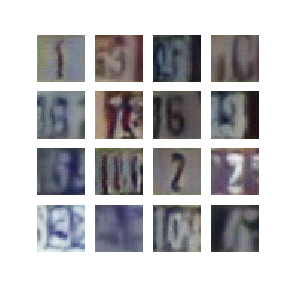

In [33]:
display.Image(savedir+'/image_at_epoch_{:04d}.png'.format(EPOCHS))

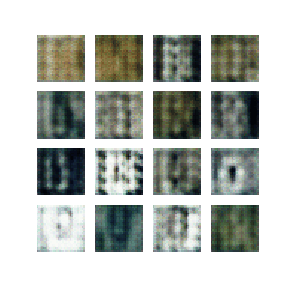

In [34]:
display.Image(filename=anim_file)

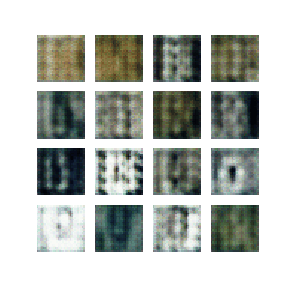

In [40]:
from IPython.display import Image
Image(filename=(anim_file+'.png'))